# Parsing promoter data

Last updated: January 28, 2019

Created by: Miguel A. Alcantar


This notebook parses through data from various promoter databases and concatenates the data into a dataframe.

To-do:
1. Clean-up code
2. Convert code to functions

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# package versions 

print("Pandas: v" + pd.__version__) 
print("Numpy: v" + np.__version__)

Pandas: v0.25.1
Numpy: v1.17.2


# Helper functions

### functions for filtering and QC

In [26]:
def calc_range(promoter_sequence_df):
    
    """
    calculate range of provided promoter sequences, with respect to the TSS. 
    this is done based on the delimiter '/', which surrounds the TSS (+1).
    
    inputs: dataframe containing promoter sequences. sequences must be under column
    named "range (with respect to TSS)".
    
    outputs: dataframe containing promoter sequences with updated "range (with respect to TSS)".
    """
    
    # loop through dataframe and update range if there is a '/' marking the TSS
    for idx, sequence in promoter_sequence_df['DNA sequence'].iteritems():
        
        if '/' in sequence:
                seq_split = sequence.split('/')
                TSS_upstream_len = str(len(seq_split[0]) - 1)
                TSS_downstream_len = str(len(seq_split[2]) + 1)
                range_string = '-' + TSS_upstream_len + ' to ' + TSS_downstream_len
                promoter_sequence_df.loc[idx, 'range (with respect to TSS)'] = range_string
                
    return(promoter_sequence_df)

def QC_DNA_sequences(promoter_sequence_df):
    
    """
    perform quality control (QC) and filter dna promoter sequences. QC involves the following:
    i) remove unwanted char acters: line-break character '\n', spaces, and brackets
    ii) use the "calc_range" function to update missing ranges with a known TSS
        '/' characters denoting TSS are removed after this step
    iii) replace NaN elements with empty string 
    iv) removing sequences that don't contain canonical nucleotides: a, t, c, g
    this function also prints out the number of sequences filtered
    
    inputs: dataframe containing promoter sequences. sequences must be under column
    named "range (with respect to TSS)".
    
    outputs: dataframe that has undergone QC and filtering
    """
    
    original_sequence_number = promoter_sequence_df.shape[0]
    
    if list(promoter_sequence_df['database/source'])[0] == 'EPDnew':
        db = 'EPDnew'
    elif list(promoter_sequence_df['database/source'])[0] == 'RegulonDB':
        db = 'RegulonDB'
    elif list(promoter_sequence_df['database/source'])[0] == 'DBTBS':
        db = 'DBTBS'
    elif list(promoter_sequence_df['database/source'])[0] == 'Meyer et al 2019 (PMID: 30478458)':
        db = 'bacterial inducible promoters'
    else:
        db = 'fungal inducible promoters'
    
    # remove unwanted characters from DNA sequences
    sequences = list(promoter_sequence_df['DNA sequence'])
    sequences = [str(seq).strip('\n') for seq in sequences] # remove edge '\n'
    sequences = [seq.replace('\n','') for seq in sequences] # remove other '\n'
    sequences = [seq.replace(' ','') for seq in sequences] # remove empty spaces
    sequences = [seq.lower() for seq in sequences] # convert sequences to lowercase
    sequences = [seq.replace('{', '').replace('}', '') for seq in sequences]
    
    promoter_sequence_df['DNA sequence'] = sequences
    # update range (with respect to TSS)
    promoter_sequence_df = calc_range(promoter_sequence_df)
    sequences = [seq.replace('/', '') for seq in sequences]
    
    # replace old sequences with QC sequences
    promoter_sequence_df['DNA sequence'] = sequences

    # filter rows that don't only contain nucleotide sequence
    promoter_sequence_df = promoter_sequence_df.fillna('').replace('NaN','')
    promoter_sequence_df = promoter_sequence_df[(~promoter_sequence_df['DNA sequence'].str.contains('[^atcg]')) & (promoter_sequence_df['DNA sequence'].str.len() > 0)]
    promoter_sequence_df.reset_index()
    new_sequence_number = promoter_sequence_df.shape[0]
    
    # display number of filtered sequences
    print(str(original_sequence_number-new_sequence_number) + ' sequences filtered from ' + db + ' dataset')
    
    return(promoter_sequence_df)

def rename_promoter_df_columns(promoter_sequence_df, promoter_df_or_type):
    
    """
    standardize column names for dataframe containing promoter sequences and metadata. 
    new columns are also added, according the selected database
    
    inputs: dataframe containing promoter sequences and metedata, 
            string indicating promoter database or type. valid string inputs are: "RegulonDB", DBTBS
                string input is NOT case-sensitive
    
    outputs: dataframe containing promoter sequences with updated column names
    """
    
    # standardized column names for RegulonDB dataframe
    newregulonDB_columns_list = ["RegulonDB ID", 
                                "promoter",
                                "DNA strand",
                                "location of TSS on genome",
                                "sigma factor/motif",
                                "DNA sequence",
                                "evidence",
                                "evidence confidence"]
    
    # standardized column names for DBTBS dataframe
    newDBTBS_columns_list = ['operon', 
                             'regulated gene', 
                             'absolute position', 
                             'range (with respect to TSS)',
                             'DNA sequence', 
                             'experimental evidence', 
                             'sigma factor/motif']
    
    # standardize column names and add new columns, as needed
    if promoter_df_or_type.lower() == 'regulondb':
        
        promoter_sequence_df_columns_dict = dict(zip(list(promoter_sequence_df.columns), newregulonDB_columns_list))
        promoter_sequence_df = promoter_sequence_df.rename(columns=promoter_sequence_df_columns_dict)
        promoter_sequence_df['database/source'] = "RegulonDB"
        promoter_sequence_df['organism'] = 'e_coli'
        promoter_sequence_df['range (with respect to TSS)'] = '-60 to +20'         
    
    elif promoter_df_or_type.lower() == 'dbtbs':

        promoter_sequence_df_columns_dict = dict(zip(list(promoter_sequence_df.columns), newDBTBS_columns_list))
        promoter_sequence_df = promoter_sequence_df.rename(columns=promoter_sequence_df_columns_dict)
        promoter_sequence_df['organism'] = 'b. subtilis'
        promoter_sequence_df['database/source'] = 'DBTBS'
        
        # standardize range syntax  
        DBTBS_range_list = list(promoter_sequence_df['range (with respect to TSS)'])
        DBTBS_range_list_renamed = [str(seq_range).replace(':', ' to ') for seq_range in DBTBS_range_list]
        promoter_sequence_df['range (with respect to TSS)'] = DBTBS_range_list_renamed
    else:
        print('Error! Please enter a valid promoter dataframe or type: \'RegulonDB\' or \'DBTBS\'')

    return(promoter_sequence_df)
    
def reorganize_promoter_df_columns(promoter_sequence_df):
    
    """
    reorganize promoter dataframe columns such that they are consistent between databases.
    this will involve dropping some unnecessary columns
    
    inputs: dataframe containing promoter sequences
        this dataframe will ideally have been passed through the rename_promoter_df_columns function if needed
        
    outputs: dataframe with reordered columns  
    """
    
    columns_to_conserve = ['organism', 'database/source', 'DNA sequence', 'regulated gene', 
                           'range (with respect to TSS)', 'motifs', 'sigma factor/motif', 'inducer/repressor', 'promoter']
    
    columns_to_add = list(set(columns_to_conserve) - set(promoter_sequence_df.columns))
    columns_to_drop = list(set(promoter_sequence_df.columns) - set(columns_to_conserve))
    
    # if new columns are added, populate with empty strings
    for col_to_add in columns_to_add:
        promoter_sequence_df[col_to_add] = ''
        
    promoter_sequence_df = promoter_sequence_df.drop(columns_to_drop, axis=1)
    promoter_sequence_df = promoter_sequence_df[columns_to_conserve]
    
    return(promoter_sequence_df)


### functions for finding number of motifs in datasets

In [4]:
def EPDnew_motifs(EPDnew_promoters_df, save_csv=False):
    
    """
    stratify EPDnew promoters by motif and organism
    
    inputs: EPDnew promoter dataframe, 
            boolean indicating whether to save csv
            
    outputs: dataframe containing matrix of organism x motif (nonTATA, TATA, Inr-pfa, nonInr-pfa, total)    
    
    """
    
    organism_motifs_dict = dict()
    organisms_list = list(set(EPDnew_promoters_df['organism']))
    motifs_list = list(set(EPDnew_promoters_df['sigma factor/motif']))

    # calculate number of promoters that were obtained for each organism (and further stratify by motif)
    for motif in motifs_list:
        motif_occurances_list = []
        for organism in organisms_list:
            organism_motifs_count = EPDnew_promoters_df[(EPDnew_promoters_df['sigma factor/motif'] == motif) & (EPDnew_promoters_df['organism'] == organism)].shape[0]
            motif_occurances_list.append(organism_motifs_count)
        organism_motifs_dict.update({motif: motif_occurances_list})
    
    # creating dataframe of organism x motif (a form that is useful for plotting)
    motifs_occurances_df = pd.DataFrame.from_dict(organism_motifs_dict,orient='index').transpose()
    
    # replace underscors with periods for organism name
    organisms_replace_underscore = [org.replace("_",". ") for org in organisms_list]
    reindex_motifs_occuranges_dict = dict(zip(list(motifs_occurances_df.index), organisms_replace_underscore)) 
    motifs_occurances_df = motifs_occurances_df.rename(index = reindex_motifs_occuranges_dict)
    
    # find total occurance occurance of promoters for each organism and then organize by motif
    motifs_occurances_df['total'] = motifs_occurances_df[list(motifs_occurances_df.columns)].sum(axis=1)
    motifs_occurances_df = motifs_occurances_df.sort_values(by="total")
    motifs_occurances_df = motifs_occurances_df[['nonTATA', 'TATA','Inr-pfa', 'nonInr-pfa', 'total']]
    
    # find total number of each kind of motif
    motifs_occurances_df.loc['total'] = np.nan
    motifs_occurances_df.loc['total', 'nonTATA'] = motifs_occurances_df.loc[:, 'nonTATA'].sum()
    motifs_occurances_df.loc['total', 'TATA'] = motifs_occurances_df.loc[:, 'TATA'].sum()
    motifs_occurances_df.loc['total', 'Inr-pfa'] = motifs_occurances_df.loc[:, 'Inr-pfa'].sum()
    motifs_occurances_df.loc['total', 'nonInr-pfa'] = motifs_occurances_df.loc[:, 'nonInr-pfa'].sum()
    motifs_occurances_df.loc['total', 'total'] = motifs_occurances_df.loc[:, 'total'].sum()
    
    # convert dataframe datatype to integer 
    motifs_occurances_df = motifs_occurances_df.astype('int')
    
    if save_csv:
        motifs_occurances_df.to_csv('../../data/parsed_promoter_data/20191125_EPDnew_motifs_occurances.csv')
    
    return(motifs_occurances_df)

def RegulonDB_motifs(regulonDB_promoters, save_csv=False):
    
    """
    stratify RegulonDB promoters by sigma factor that binds promoter
    
    inputs: RegulonDB promoter dataframe, 
            boolean indicating whether to save csv
            
    outputs: dataframe containing matrix of sigma factor x number of promoters
    """
    
    # define E. coli sigma factors
    sigma_factors_Ecoli = ['unknown',
                           'Sigma70',
                           'Sigma54',
                           'Sigma38',
                           'Sigma32',
                           'Sigma28',
                           'Sigma24',
                           'Sigma19']

    # dictionary that will contain promoter sigma factor frequencies             
    Ecoli_sigma_factor_count_dict = dict()

    # determine counts for each sigma factor
    for sigma_factor in sigma_factors_Ecoli:
        
        if sigma_factor == 'unknown':
            SF_count = int(regulonDB_promoters[regulonDB_promoters['sigma factor/motif'].str.contains(sigma_factor)].shape[0]) + \
                        int(regulonDB_promoters[regulonDB_promoters['sigma factor/motif'] == ''].shape[0])
        else:
            SF_count = regulonDB_promoters[regulonDB_promoters['sigma factor/motif'].str.contains(sigma_factor)].shape[0]
        
        Ecoli_sigma_factor_count_dict.update({sigma_factor: SF_count})

    # build dataframe containing sigma factor count information
    Ecoli_sigma_factor_occurances = pd.DataFrame.from_dict(Ecoli_sigma_factor_count_dict,orient='index')
    Ecoli_sigma_factor_occurances.loc['total',:] = regulonDB_promoters.shape[0]
    Ecoli_sigma_factor_occurances = Ecoli_sigma_factor_occurances.rename(columns = {0:"E. coli"}).sort_values(by="E. coli")
    Ecoli_sigma_factor_occurances = Ecoli_sigma_factor_occurances.astype('int')
    
    if save_csv:
        Ecoli_sigma_factor_occurances.to_csv('../../data/parsed_promoter_data/20191202_RegulonDB_sigma_factor_occurances.csv')
        
    return(Ecoli_sigma_factor_occurances)

def DBTBS_motifs(DBTBS_promoters_df, save_csv=False):
    
    """
    stratify DBTBS promoters by sigma factor that binds promoter
    
    
    inputs: DBTBS promoter dataframe, 
            boolean indicating whether to save csv
            
    outputs: dataframe containing matrix of sigma factor x number of promoters
    """
      
    sigma_factors_Bsubtilis = list(set(DBTBS_promoters_df['sigma factor/motif']))
    Bsubtilis_sigma_factor_count_dict = dict()

    # loop through sigma factors to find counts of each sigma factor type
    for sigma_factor in sigma_factors_Bsubtilis:
        SF_count = DBTBS_promoters_df[DBTBS_promoters_df['sigma factor/motif'].str.contains(sigma_factor[0:5])].shape[0]
        Bsubtilis_sigma_factor_count_dict.update({sigma_factor: SF_count})
        
    Bsubtilis_sigma_factor_occurances = pd.DataFrame.from_dict(Bsubtilis_sigma_factor_count_dict,orient='index')
    Bsubtilis_sigma_factor_occurances.loc["total",:] = DBTBS_promoters_df.shape[0]
    Bsubtilis_sigma_factor_occurances = Bsubtilis_sigma_factor_occurances.rename(columns = {0:"B. subtilis"}).sort_values(by="B. subtilis")
    Bsubtilis_sigma_factor_occurances = Bsubtilis_sigma_factor_occurances.astype('int')

    if save_csv:
        Bsubtilis_sigma_factor_occurances.to_csv("../../data/parsed_promoter_data/20191129_DBTBS_sigma_factor_occurances.csv")
        
    return(Bsubtilis_sigma_factor_occurances)
    

# EPDnew

### Contains sequences for 15 different eukaryotic species

1. C. elegans (worm)
2. D. melanogaster (fly)
3. D. rerio (zebrafish)
4. R. norbegicus (rat)
5. Z. mays (maize)
6. H. sapien (humans)
7. G. gallus (chicken)
8. S. pombe (fission yeast)
9. A. thaliana (arabidopsis)
10. M. mulatta (monkey)
11. P. falciparum (malaria-causing parasite)
12. M. musculus (mouse)
13. S. cerevisiae (yeast)
14. A. mellifera (bee)
15. C. familiaris (dog)

In [5]:
def parse_EPDnew(save_csv=False):
    """
    parse through EPDnew database and apply QC / filtering
    
    inputs: boolean argument indicating whether csv files should be saved
    
    outputs: dataframe containing EPDnew promoters and metadata,
            if save_csv, then csv file is saved to data directory
    
    """
        
    # hard-coding directory containing data of interest
    directory_str = '../../data/EPDnew'
    directory = os.fsencode(directory_str)

    # initializing lists that will contain information of interest
    promoter_organism = []
    promoter_database = []
    promoter_sequences = []
    promoter_gene = []
    promoter_range = []
    promoter_notes = []

    # loop through all files 
    # each file contains promoters for a particular organism and motif (e.g., h. sapien TATA promoters)
    for file in os.listdir(directory):

        # establishing file path and name
        filename = os.fsdecode(file)
        filepath = directory_str + '/' + filename

        # initializing gene number and sequence (the latter helps with appending sequences to list)
        counter_gene = 0 
        sequence = ''
        
        # ignore hidden files
        if filename[0] != '.': 
            
            with open(filepath) as fp:

                line = fp.readline()

                while line:

                    # The '>' signifies the start of a new gene
                    if line[0] == '>':

                        # append last completed sequence if we've already been through 1 iteration
                        if counter_gene >= 1:

                            promoter_sequences.append(sequence)
                            
                        sequence = ''
                        counter_gene += 1
                        
                        line_split = line.split(' ')

                        # extracting gene regulated by the current promoter
                        promoter_gene.append(line_split[1])

                        # edge case where gene does not have a specified range
                        try:
                            range_index = line.split(' ').index('range')
                            range_temp = line.split(' ')[range_index+2] + ' to ' + line.split(' ')[range_index+6].strip('.\n')
                            promoter_range.append(range_temp)
                        except ValueError:
                            promoter_range.append('')

                        # append organism name, database where promoter was obtained, and notes (e.g., TATA or nonTATA promoter)
                        promoter_organism.append(filename.split('_')[2] + '_' + filename.split('_')[3])
                        promoter_database.append(filename.split('_')[1])
                        promoter_notes.append(filename.split('_')[4].replace(' ',''))

                    else: # keep appending nucleotides until we reach a new sequence
                        sequence = sequence + line
                    line = fp.readline()
            promoter_sequences.append(sequence)

        # organizing data into a dictionary
        EPDnew_data_dict = {
            'organism': promoter_organism,
            'database/source': promoter_database,
            'DNA sequence':promoter_sequences,
            'regulated gene': promoter_gene,
            'range (with respect to TSS)': promoter_range,
            'sigma factor/motif': promoter_notes
                            }

    # organizing data into dataframe
    EPDnew_promoters_df = pd.DataFrame.from_dict(EPDnew_data_dict,orient='index').transpose()
    EPDnew_promoters_df = QC_DNA_sequences(EPDnew_promoters_df) 
    
    # save as csv 
    if save_csv:
        EPDnew_promoters_df.to_csv('../../data/parsed_promoter_data/20191125_EPDnew_promoters.csv')
    
    return(EPDnew_promoters_df)


In [6]:
# creating stacked barplot showing number of promoters from each organism and their specific motifs
def plot_EPDnew_data(motifs_occurances_df, save_plot=False):
    
    """
    create bar plot showing EPDnew promoters stratified by organism and motif
    
    # inputs: dataframe containing EPDnew organisms x motifs (the output of EPDnew_motifs function)
    
    # outputs: if save_plot, then a bar plot is saved
    """
    
    dark_blue = '#4D98FA'
    dark_yellow = '#FAAE65'
    light_blue = '#60B5E6'
    purple = '#CC7DAA'
    plot_colors = [dark_blue, dark_yellow, light_blue, purple]

    # create horizontal barplot that specifies promoter by organism and motif
    motifs_occurances_df.iloc[:,:-1].plot.barh(stacked=True, color = plot_colors ,figsize=(10,7))
    plt.xlabel('Count', size=24,fontname="Arial"),
    plt.ylabel('Organism', size=24,fontname="Arial")
    plt.title('Promoter counts by organism and motif',fontname="Arial", size=24)
    plt.xticks(fontsize = 16,fontname="Arial") 
    plt.yticks(fontsize = 16,fontname="Arial")
    plt.legend(loc='lower right', prop={'size': 16})
    plt.tight_layout()

    if save_plot:
        plt.savefig('../../figs/promoter_database_summaries/20191127_EPDnew_promoters_by_organisms_and_motifs.pdf')
        plt.savefig('../../figs/promoter_database_summaries/20191127_EPDnew_promoters_by_organisms_and_motifs.png', dpi=400)
        plt.savefig('../../figs/promoter_database_summaries/20191127_EPDnew_promoters_by_organisms_and_motifs.svg')





1459 sequences filtered from EPDnew dataset


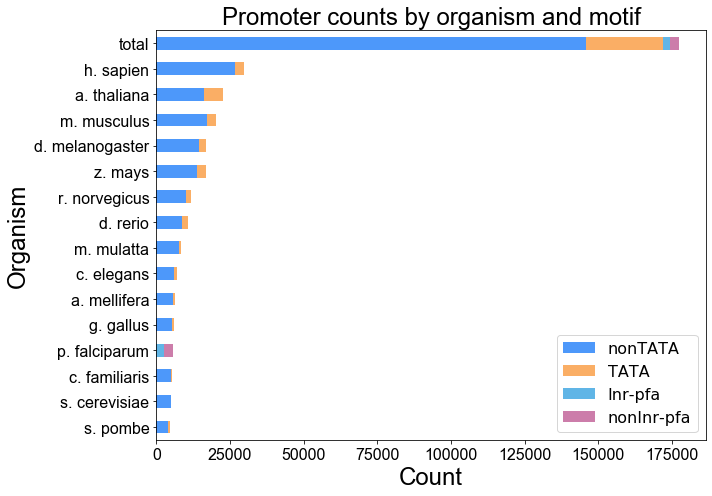

In [7]:
# run EPDnew functions
EPDnew_promoters_df = parse_EPDnew(save_csv=False)
motifs_occurances_df = EPDnew_motifs(EPDnew_promoters_df)
plot_EPDnew_data(motifs_occurances_df, save_plot=False) # plot EPDnew data

# edit EPDnew dataframe such that it is compatible for concatenation
EPDnew_promoters_df_to_concat = reorganize_promoter_df_columns(EPDnew_promoters_df)

# RegulonDB

### Contains sequences for different E. coli polymerase sigma factors (70, 54, 38, 32, 28, 24, 19)

In [8]:
def parse_RegulonDB(save_csv=False):
    
    """
    parse through RegulonDB database and apply QC / filtering
    
    inputs: boolean argument indicating whether csv files should be saved
    
    outputs: dataframe containing RegulonDB promoters and metadata,
            if save_csv, then csv file is saved to data directory
    
    """
        
    # Download regulon DB promoter database and organize dataframe
    regulonDB_promoters_df = pd.read_csv('../../data/RegulonDB/20191127_PromoterSet.csv', header=36)
    regulonDB_promoters_df = rename_promoter_df_columns(regulonDB_promoters_df,promoter_df_or_type='RegulonDB')
    regulonDB_promoters_df = QC_DNA_sequences(regulonDB_promoters_df)

    if save_csv:
        regulonDB_promoters_df.to_csv('../../data/parsed_promoter_data/20191202_RegulonDB_promoters.csv')
    
    return(regulonDB_promoters_df)
        

In [9]:
def plot_RegulonDB_data(Ecoli_sigma_factor_occurances, save_plot=False):   
        
    """
    create bar plot showing RegulonDB promoters stratified by cognate sigma factor
    
    # inputs: dataframe containing RegulonDB organisms x motifs (the output of RegulonDB_motifs function)
    
    # outputs: if save_plot, then a bar plot is saved
    """
    
    # plot promoter counts by sigma factor
    Ecoli_sigma_factor_occurances.astype(int).plot.barh(figsize=(10,7), color = '#C4C4C4')
    plt.xlabel('Count', size=24,fontname="Arial")
    plt.ylabel('E. coli sigma factor', size=24,fontname="Arial")
    plt.title('E. coli promoter counts by sigma factor', size=24,fontname="Arial")
    plt.xticks(fontsize = 16,fontname="Arial") # work on current fig
    plt.yticks(fontsize = 16,fontname="Arial") # work on current fig
    plt.legend(loc='lower right', prop={'size': 16})
    plt.tight_layout()

    if save_plot:
        plt.savefig('../../figs/promoter_database_summaries/20191127_RegulonDB_promoters_by_ecoli_sigmaFactor.pdf')
        plt.savefig('../../figs/promoter_database_summaries/20191127_RegulonDB_promoters_by_ecoli_sigmaFactor.png', dpi=400)
        plt.savefig('../../figs/promoter_database_summaries/20191127_RegulonDB_promoters_by_ecoli_sigmaFactor.svg')



92 sequences filtered from RegulonDB dataset


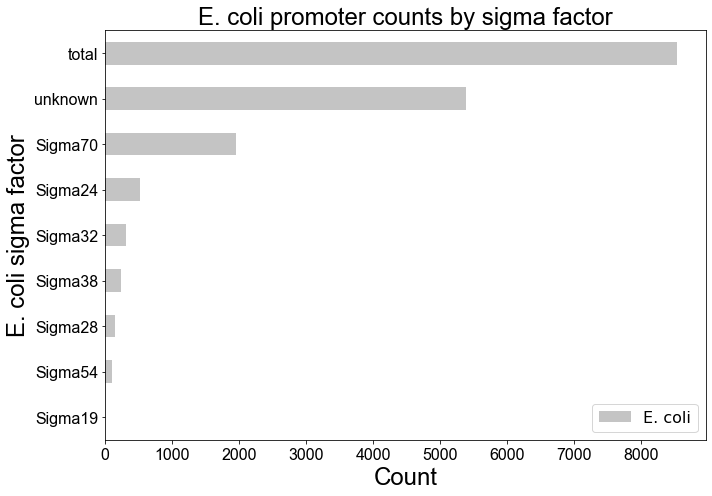

In [27]:
# run RegulonDB functions
regulonDB_promoters_df = parse_RegulonDB(save_csv=False)
Ecoli_sigma_factor_occurances = RegulonDB_motifs(regulonDB_promoters_df, save_csv=False)
plot_RegulonDB_data(Ecoli_sigma_factor_occurances, save_plot=False)

# edit RegulongDB dataframe such that it is compatible for concatenation
regulonDB_promoters_df_to_concat = reorganize_promoter_df_columns(regulonDB_promoters_df)

# DBTBS
### Contains sequences for different B. subtilis polymerase sigma factors

In [28]:
def parse_DBTBS(save_csv=False):
    
    """
    parse through DBTBS database and apply QC / filtering
    
    inputs: boolean argument indicating whether csv files should be saved
    
    outputs: dataframe containing DBTBS promoters and metadata,
            if save_csv, then csv file is saved to data directory
    
    """    
    
    # merge Bacillus subtilus promoter excel sheets into one comprehensive dataframe
    DBTBS_all_promoter_sheets_df = pd.read_excel('../../data/DBTBS/20191129_DBTBS_promoter_sequences.xlsx', sheet_name=None, ignore_index=True)
    DBTBS_promoters_df = pd.concat(DBTBS_all_promoter_sheets_df.values()).fillna('')# #dropna(thresh=1)
    DBTBS_promoters_df.reset_index(drop=True, inplace=True)
    DBTBS_promoters_df = rename_promoter_df_columns(DBTBS_promoters_df, promoter_df_or_type='DBTBS')
    
    DBTBS_promoters_df = QC_DNA_sequences(DBTBS_promoters_df)
    
    # save to csv
    if save_csv:
        DBTBS_promoters_df.to_csv("../../data/parsed_promoter_data/20191129_DBTBS_promoter_sequences.csv")
        
    return(DBTBS_promoters_df)


In [29]:
def plot_DBTBS_data(Bsubtilis_sigma_factor_occurances, save_plot=False):

    """
    create bar plot showing DBTBS promoters stratified by cognate sigma factor
    
    # inputs: dataframe containing DBTBS organisms x motifs (the output of DBTBS_motifs function)
    
    # outputs: if save_plot, then a bar plot is saved
    """
    
    Bsubtilis_sigma_factor_occurances.astype(int).plot.barh(figsize=(10,7), color = '#6E8DAB')
    plt.xlabel('Count', size=24,fontname="Arial"),
    plt.ylabel('B. subtilis sigma factor', size=24,fontname="Arial")
    plt.title('B. subtilis promoter counts by sigma factor', size=24,fontname="Arial")
    plt.xticks(fontsize = 16) # work on current fig
    plt.yticks(fontsize = 16) # work on current fig
    plt.legend(loc='lower right', prop={'size': 16})
    plt.tight_layout()
    
    if save_plot:
        plt.savefig('../../figs/promoter_database_summaries/20191127_DBTBS_promoters_by_Bsubtilis_sigmaFactor.pdf')
        plt.savefig('../../figs/promoter_database_summaries/20191127_DBTBS_promoters_by_Bsubtilis_sigmaFactor.png', dpi=400)
        plt.savefig('../../figs/promoter_database_summaries/20191127_DBTBS_promoters_by_Bsubtilis_sigmaFactor.svg')
    
    

264 sequences filtered from DBTBS dataset


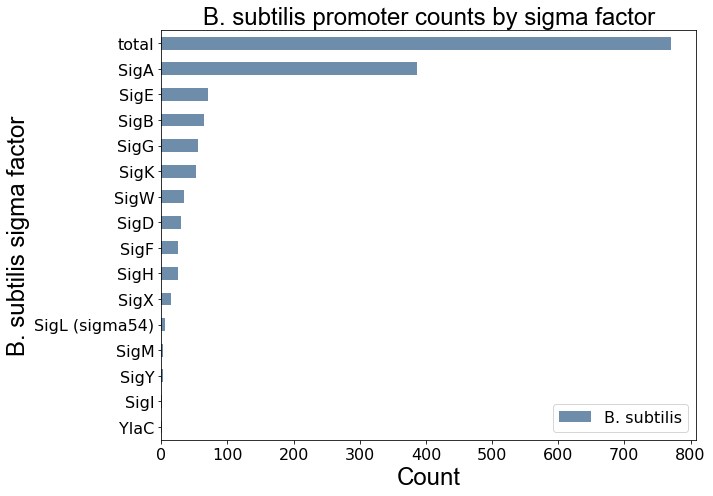

In [30]:
# run DBTBS functions
DBTBS_promoters_df = parse_DBTBS(save_csv=False) #Bsubtilis_sigma_factor_occurances
Bsubtilis_sigma_factor_occurances = DBTBS_motifs(DBTBS_promoters_df, save_csv=False)
plot_DBTBS_data(Bsubtilis_sigma_factor_occurances, save_plot=False)

# edit DBTBS dataframe such that it is compatible for concatenation
DBTBS_promoters_df_to_concat = reorganize_promoter_df_columns(DBTBS_promoters_df)

# Inducible promoters

In [ ]:
def parse_bacterial_inducible_promoters(save_csv=True):

    """
    parse through bacterial inducible promoters obtained from Meyer et al 2019 and apply QC / filtering
    
    inputs: boolean argument indicating whether csv files should be saved
    
    outputs: dataframe containing bacterial inducible promoters and metadata,
            if save_csv, then csv file is saved to data directory
    
    """  

    # load raw inducible promoter dataframe
    inducible_promoters_bact_df = pd.read_excel('../../data/inducible_promoters/20191202_inducible_promoters_bacteria.xlsx')

    inducible_promoters_bact_df = QC_DNA_sequences(inducible_promoters_bact_df)

    if save_csv:
        inducible_promoters_bact_df.to_csv("../../data/parsed_promoter_data/20191129_bacterial_inducible_promoters.csv")
        
    
    return(inducible_promoters_bact_df)


In [ ]:
# run bacterial inducible promoters functions
inducible_promoters_bact_df = parse_bacterial_inducible_promoters(save_csv=False)
inducible_promoters_bact_df_to_concat = reorganize_promoter_df_columns(inducible_promoters_bact_df)


In [ ]:
def parse_fungal_inducible_promoters(save_csv=False):
    
    """
    parse through fungal inducible promoters obtained from various sources and apply QC / filtering
    
    inputs: boolean argument indicating whether csv files should be saved
    
    outputs: dataframe containing DBTBS promoters and metadata,
            if save_csv, then csv file is saved to data directory
    
    """
    
    # load raw inducible promoter dataframe
    inducible_promoters_fungus_df = pd.read_excel('../../data/inducible_promoters/20191210_inducible_promoters_fungus.xlsx')
    
    inducible_promoters_fungus_df = QC_DNA_sequences(inducible_promoters_fungus_df)

    if save_csv:
        inducible_promoters_fungus_df.to_csv("../../data/parsed_promoter_data/20200128_fungal_inducible_promoter_sequences.csv")

    return(inducible_promoters_fungus_df)


In [ ]:
# run fungal inducible promoters functions
inducible_promoters_fungus_df = parse_fungal_inducible_promoters(save_csv=False)
inducible_promoters_fungus_df_to_concat = reorganize_promoter_df_columns(inducible_promoters_fungus_df)


In [ ]:
def inducible_promoters_count(inducible_promoters_bact_df_to_concat, inducible_promoters_fungus_df_to_concat, save_csv=False):
    
    """
    stratify inducible promoters by organism (e.g., fungal, bacterial, mammalian)
    
    inputs: dataframes for bacterial and fungal inducible promoters
    
    outputs: dataframe containing inducible promoter counts
    """

    bact_inducible_promoters = list(inducible_promoters_bact_df_to_concat['promoter'])
    bact_inducible_promoter_varients_count = 0

    # counting promoter varients
    for induc_prom in bact_inducible_promoters:
        if 'varient' in induc_prom:
            bact_inducible_promoter_varients_count += 1

    fungus_inducible_promoter_varients_count = 0

    mammalian_inducible_promoter_varients_count = 0


    inducible_promoters_counts_df = pd.DataFrame(columns = ["Promoters total", "Original promoters", "Varients"])
    inducible_promoters_counts_df.loc['Mammalian', 'Promoters total'] = 6
    inducible_promoters_counts_df.loc['Bacteria', 'Promoters total'] = inducible_promoters_bact_df_to_concat.shape[0]
    inducible_promoters_counts_df.loc['Fungi', 'Promoters total'] = inducible_promoters_fungus_df_to_concat.shape[0]

    inducible_promoters_counts_df.loc['Mammalian', 'Original promoters'] = 6 - mammalian_inducible_promoter_varients_count
    inducible_promoters_counts_df.loc['Bacteria', 'Original promoters'] = inducible_promoters_bact_df_to_concat.shape[0] - bact_inducible_promoter_varients_count
    inducible_promoters_counts_df.loc['Fungi', 'Original promoters'] = inducible_promoters_fungus_df_to_concat.shape[0] - fungus_inducible_promoter_varients_count

    inducible_promoters_counts_df.loc['Mammalian', 'Varients'] = mammalian_inducible_promoter_varients_count
    inducible_promoters_counts_df.loc['Bacteria', 'Varients'] = bact_inducible_promoter_varients_count
    inducible_promoters_counts_df.loc['Fungi', 'Varients'] = fungus_inducible_promoter_varients_count

    inducible_promoters_counts_df = inducible_promoters_counts_df.sort_values(by="Promoters total")
    inducible_promoters_counts_df = inducible_promoters_counts_df.astype('int')
    
    if save_csv:
        inducible_promoters_counts_df.to_csv('../../data/parsed_promoter_data/20200128_inducible_promoter_counts.csv')
    return(inducible_promoters_counts_df)


In [ ]:
def plot_inducible_promoters(inducible_promoters_counts_df, save_plot=True):

    """
    create bar plot showing DBTBS promoters stratified by cognate sigma factor
    
    # inputs: dataframe containing DBTBS organisms x motifs (the output of DBTBS_motifs function)
    
    # outputs: if save_plot, then a bar plot is saved
    """
    
    black = '#000000'
    dark_slate_gray = '#2F4F4F'
    plot_colors = [black, dark_slate_gray]


    inducible_promoters_counts_df.iloc[:,1:].plot.barh(stacked=True, color = plot_colors, figsize=(10,7))
    plt.xlabel('Count', size=24,fontname="Arial")
    plt.ylabel('Organism', size=24,fontname="Arial")
    plt.title('Inducible promoter counts',fontname="Arial", size=24)
    plt.xticks(fontsize = 16,fontname="Arial") 
    plt.yticks(fontsize = 16,fontname="Arial")
    plt.legend(loc='lower right', prop={'size': 16})
    plt.tight_layout()
    
    if save_plot:
        plt.savefig('../../figs/promoter_database_summaries/20191210_inducible_promoter_counts.pdf')
        plt.savefig('../../figs/promoter_database_summaries/20191210_inducible_promoter_counts.png', dpi=400)
        plt.savefig('../../figs/promoter_database_summaries/20191210_inducible_promoter_counts.svg')
        



In [ ]:
# run functions for inducible promoter counts and plot these counts
inducible_promoters_counts_df = inducible_promoters_count(inducible_promoters_bact_df_to_concat, inducible_promoters_fungus_df_to_concat)
plot_inducible_promoters(inducible_promoters_counts_df, save_plot=False)


In [ ]:
# concatenate promoters
promoters_df = pd.concat([EPDnew_promoters_df_to_concat, 
           regulonDB_promoters_df_to_concat,
           DBTBS_promoters_df_to_concat,
           inducible_promoters_bact_df_to_concat,
            inducible_promoters_fungus_df_to_concat], 
            sort=False).reset_index().drop('index', axis=1)

promoters_df.to_csv("../../data/parsed_promoter_data/20191203_promoters.csv")